In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook, tnrange
%matplotlib inline

# Bajar el dataset de imágenes

Download http://download.tensorflow.org/example_images/flower_photos.tgz

`> tar -xvzf flower_photos.tgz`

# Cargando las imagenes

Vamos a usar la clase [ImageDataGenerator](https://keras.io/preprocessing/image/) de keras para cargar las imagenes, esta clase nos ayuda a cargar las imagenes en batch, a aplicarles una función de preprocesamiento y aplicar data augmentation.

In [2]:
path = '/home/rhermoza/datasets/flower_photos/'
img_size = 224
batch_size = 64

In [3]:
# Especificamos la función de preprocesamiento
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Usamos la función "flow_from_directory" para cargar las imagenes desde un folder.

La estructura de la carpeta que espera la función es importante. Cada clase de nuestro dataset tiene que estar dentro de una carpeta con el nombre de la clase:

* path:
  - class1
    - img1, img2, img3, ...
  - class2
    - img1, img2, img3, ...
  - class3
    - img1, img2, img3, ...

Es una estructura común en los datasets de imágenes.

In [4]:
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size), batch_size=batch_size)

Found 3670 images belonging to 5 classes.


In [5]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [6]:
# Si queremos el nombre de los archivos, el parámetro filenames guarda la ruta de las imágenes
train_generator.filenames[:3]

['daisy/100080576_f52e8ee070_n.jpg',
 'daisy/10140303196_b88d3d6cec.jpg',
 'daisy/10172379554_b296050f82_n.jpg']

tulips/3404038663_f62cf8eba3_n.jpg


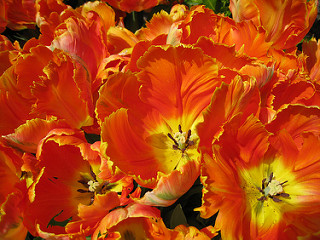

In [7]:
# Veamos alguna de las imágenes
random_img = np.random.choice(train_generator.filenames)
print(random_img)
Image.open(path + random_img)

In [8]:
# Veamos como se extrae un batch del generator
batch_x, batch_y = train_generator.next()
batch_x.shape, batch_y.shape

((64, 224, 224, 3), (64, 5))

# Cargar una red entrenada

Vamos a cargar la red **ResNet50** ya entrenada, pero sin incluir las capas densas, ya que vamos a adaptar la red a nuestro caso específico.

In [13]:
base_model = ResNet50(include_top=False, input_shape=(img_size,img_size,3), pooling='avg')
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
base_model.input, base_model.output

(<tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'global_average_pooling2d_1/Mean:0' shape=(?, 2048) dtype=float32>)

In [15]:
# Dado que solo queremos entrenar las capas densas del modelo que agregaremos
# en el siguiente paso, vamos a setear "trainable = False" para que los pesos
# de la red entrenada no cambien.
base_model.trainable = False

# Creamos un modelo con capas densas

In [17]:
flowers_model = Sequential()

flowers_model.add(Dense(128, activation='relu', input_shape=(2048,)))
flowers_model.add(Dense(5, activation='softmax'))

flowers_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
flowers_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 262,917
Trainable params: 262,917
Non-trainable params: 0
_________________________________________________________________


# Juntamos los 2 modelos

In [19]:
final_model = Sequential()

final_model.add(base_model)
final_model.add(flowers_model)

final_model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(0.001),
                      metrics=['accuracy'])
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 5)                 262917    
Total params: 23,850,629
Trainable params: 262,917
Non-trainable params: 23,587,712
_________________________________________________________________


Observa la cantidad de parametros entrenables.

# Entrenando en nuestro dataset

In [20]:
log = final_model.fit_generator(train_generator)

Epoch 1/1
58/58 [==============================] - 16s 275ms/step - loss: 0.4911 - acc: 0.8193


La red de base que estamos usando (ResNet50) tiene bastantes capas y hacer todas estas operaciones toma un tiempo considerable, en CPU hacer este entrenamiento puede resultar impractico.

# Precompute

Si tenemos en cuenta que vamos a entrenar nuestro dataset un cierto número de épocas, en cada época se van a repetir exactamente las mismas operaciones en la misma data. Para no redundar, es bastante útil hacer un precompute de la data:
1. Pasar todas nuestras imagenes por la red base (ResNet50).
2. Guardamos los features extraidos.
3. Entrenamos las capas densas con los features extraidos.

In [41]:
# Vamos a crear nuevamente el generator, pero esta vez con el parámetro "shuffle=False",
# para obtener los resultados en orden
train_generator = train_datagen.flow_from_directory(path, target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False)

Found 3670 images belonging to 5 classes.


In [42]:
n_batch = math.ceil(train_generator.samples / batch_size)
n_batch

58

In [44]:
# Reseteamos el status del generador para comenzar en orden
train_generator.reset()

# Variables donde vamos a guardar los features extraidos
outputs_x = []
outputs_y = []

# Usamos "tnrange" en lugar de "range" para tener más información del loop
for i in tnrange(n_batch):
    # Obtenemos la información del batch
    batch_x, batch_y = train_generator.next()

    # Guardamos el resultado del base_model
    outputs_x.append(base_model.predict_on_batch(batch_x))
    
    # Guardamos tambien los labels
    outputs_y.append(batch_y)

In [45]:
# Usamos la función "vstack" de numpy, para juntar los resultados en forma de un numpy array
outputs_x = np.vstack(outputs_x)
outputs_y = np.vstack(outputs_y)
outputs_x.shape, outputs_y.shape

((3670, 2048), (3670, 5))

In [49]:
# Guardamos los arrays
np.savez_compressed('data/flower_precomputed', x=outputs_x, y=outputs_y)

In [52]:
# Cargar arrays
data = np.load('data/flower_precomputed.npz')
outputs_x = data['x']
outputs_y = data['y']

outputs_x.shape, outputs_y.shape

((3670, 2048), (3670, 5))

# Entrenar a partir de los features extraidos

In [54]:
# Ahora podemos usar un batch_size mas grande, ya que los features son mas pequeños
# que las imagenes.
log = flowers_model.fit(outputs_x, outputs_y, epochs=5, batch_size=256)

Epoch 1/5
3670/3670 [==============================] - 2s 460us/step - loss: 0.2894 - acc: 0.8995
Epoch 2/5
3670/3670 [==============================] - 0s 20us/step - loss: 0.1618 - acc: 0.9444
Epoch 3/5
3670/3670 [==============================] - 0s 21us/step - loss: 0.1166 - acc: 0.9635
Epoch 4/5
3670/3670 [==============================] - 0s 23us/step - loss: 0.0796 - acc: 0.9804
Epoch 5/5
3670/3670 [==============================] - 0s 25us/step - loss: 0.0564 - acc: 0.9891


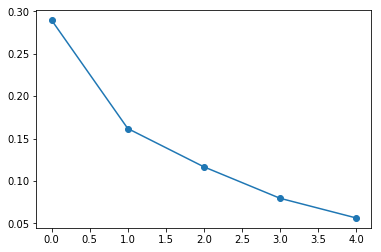

In [56]:
plt.plot(log.history['loss'], '-o');

# Ejercicio: usando el modelo completo

Dado el path de una imagen, retornar las top 5 predicciones del modelo.

In [73]:
# Para obtener la clase de una predicción, tenemos que identificar el indice del array
# con el valor más alto, para esto usamos la función "np.argmax", ej:
np.argmax([0, 0, 1, 0, 0])

2

In [74]:
# Para identificar el label que pertene a una prediccion usamos el diccionario
# creado en el "train_generator"
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [77]:
# Pero necesitamos invertir el diccionario
lbl_dict = {k:i for i,k in train_generator.class_indices.items()}
lbl_dict

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

In [78]:
lbl_dict[2]

'roses'

In [80]:
def get_class(path):
    # Cargar la imagen del path
    img = # completar
    
    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')
    
    # Cambiar el tamaño de la imagen
    img_resized = # completar
    
    # Cambiar a formato numpy y preprocesar
    x = # completar
    
    # Obtener predicciones
    y = # completar
    
    # Decodear predicciones
    preds = lbl_dict[np.argmax(y)]
    
    return preds

/home/rhermoza/datasets/flower_photos/dandelion/13734221225_0e04edc6b6.jpg


'dandelion'

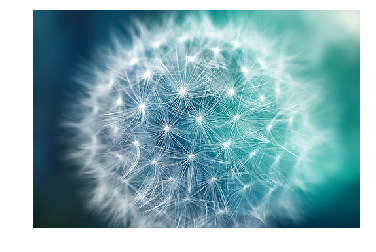

In [84]:
# Escoger una imagene al azar
random_path = path + np.random.choice(train_generator.filenames)
print(random_path)

# Obtener la clasificación de la imagen
get_class(random_path)